In [165]:
#######Regression###########
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge,Lasso,RidgeCV, ElasticNet, LassoCV, LassoLarsCV,LinearRegression
from sklearn.kernel_ridge import KernelRidge
from vecstack import stacking
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [191]:
target_var = 'RPY_3YR_RT_SUPP'plot
df = pd.read_csv('trans2.csv')
df = df.drop(['Unnamed: 0',"Binary_25k"], axis=1)
df = df.apply(lambda x: x.fillna(x.median()),axis=0)
df[pd.notnull(df[target_var])]
train_X = df.loc[:, df.columns != target_var]
train_Y = df[target_var]


In [192]:
df_test = pd.read_csv('trans2_test.csv')
df_test = df_test.drop(['Unnamed: 0',"Binary_25k"], axis=1)
df_test = df_test.dropna()
test_X = df_test.loc[:, df_test.columns != target_var]
test_Y = df_test[target_var]

In [193]:
#ExtraTrees 
ExtC = ExtraTreesRegressor()
## Search grid for optimal parameters
ex_param_grid = {"max_depth": [5],
              "max_features": [1, 3, 5, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,200,500]
              }


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="neg_mean_squared_error", n_jobs= 4, verbose = 1)

gsExtC.fit(train_X,train_Y)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   33.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  2.2min finished


-0.013821747045690672

In [194]:
RFC = RandomForestRegressor()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [5],
              "max_features": [1, 3, 5,10],
              #"min_samples_split": [2, 3, 10],
              #"min_samples_leaf": [1, 3, 10],
              #"bootstrap": [False],
              "n_estimators" :[100,200,500]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold,scoring="neg_mean_squared_error", n_jobs= 4, verbose = 1)

gsRFC.fit(train_X,train_Y)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   24.0s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:   46.7s finished


-0.012329913802004724

In [195]:
GBC = GradientBoostingRegressor()
gb_param_grid = {
              'n_estimators' : [100,200,500],
              'learning_rate': [0.05,0.02,0.01,0.005],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold,scoring="neg_mean_squared_error",n_jobs= 4, verbose = 1)

gsGBC.fit(train_X,train_Y)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   50.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 480 out of 480 | elapsed:  2.2min finished


-0.0096856243864060308

In [196]:
LR = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(LR,parameters, scoring="neg_mean_squared_error",cv=kfold)
grid.fit(train_X,train_Y)
LR_best = grid.best_estimator_
grid.best_score_

-0.016375068033452397

In [197]:
DTC = DecisionTreeRegressor()

adaDTC = AdaBoostRegressor(DTC, random_state=7)

ada_param_grid = {
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators" :[30,50],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="neg_mean_squared_error", n_jobs= 4, verbose = 1)

gsadaDTC.fit(train_X,train_Y)

ada_best = gsadaDTC.best_estimator_
gsadaDTC.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   41.1s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:   54.6s finished


-0.0097881168303177533

In [198]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

##########regression ensemble###################
models = [
    ada_best,
    GBC_best,
    RFC_best,
    ExtC_best
    
#     XGBClassifier(seed = 0, n_jobs = -1, learning_rate = 0.1, 
#         n_estimators = 100, max_depth = 3)]
    ]

# Compute stacking features
S_train, S_test = stacking(models, train_X.values, train_Y.values, test_X.values, 
    regression = True, metric = mean_squared_error, n_folds = 10, 
    stratified = True, shuffle = True, random_state = 0, verbose = 2)

/Users/charles/anaconda3/lib/python3.6/site-packages/vecstack/core.py:459: UserWarning: This is regression task hence classification-specific parameters set to <True> were ignored: <stratified>
  warnings.warn(warn_str, UserWarning)


task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [4]

model  0:     [AdaBoostRegressor]
    fold  0:  [0.01116470]
    fold  1:  [0.00885878]
    fold  2:  [0.00921357]
    fold  3:  [0.00996035]
    fold  4:  [0.00965272]
    fold  5:  [0.01061728]
    fold  6:  [0.00862992]
    fold  7:  [0.01089775]
    fold  8:  [0.00829597]
    fold  9:  [0.00892968]
    ----
    MEAN:     [0.00962207] + [0.00095313]
    FULL:     [0.00962213]

model  1:     [GradientBoostingRegressor]
    fold  0:  [0.01105573]
    fold  1:  [0.00837176]
    fold  2:  [0.00908230]
    fold  3:  [0.00962312]
    fold  4:  [0.00936167]
    fold  5:  [0.01063704]
    fold  6:  [0.00902187]
    fold  7:  [0.01041756]
    fold  8:  [0.00819435]
    fold  9:  [0.00955254]
    ----
    MEAN:     [0.00953179] + [0.00089234]
    FULL:     [0.00953178]

model  2:     [RandomForestRegressor]
    fold  0:  [0.01425768]
    fold  1:  [0.01176190]
    fold  2:  [0.0118154

In [209]:
model = GradientBoostingRegressor()

# Fit 2-nd level model
model.fit(S_train, train_Y)

# Predict
y_pred = model.predict(S_train)


# Final prediction score
print('Final train mse score: [%.8f]' % mean_squared_error(train_Y, y_pred))

# Predict
y_pred = model.predict(S_test)

# Final prediction score
print('Final test mse score: [%.8f]' % mean_squared_error(test_Y, y_pred))

Final train mse score: [0.00789646]
Final test mse score: [0.00936072]


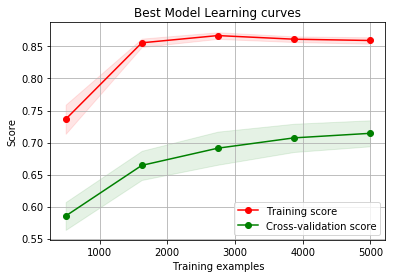

In [216]:
g = plot_learning_curve(GBC_best,"Best Model Learning curves",train_X,train_Y,cv=kfold)

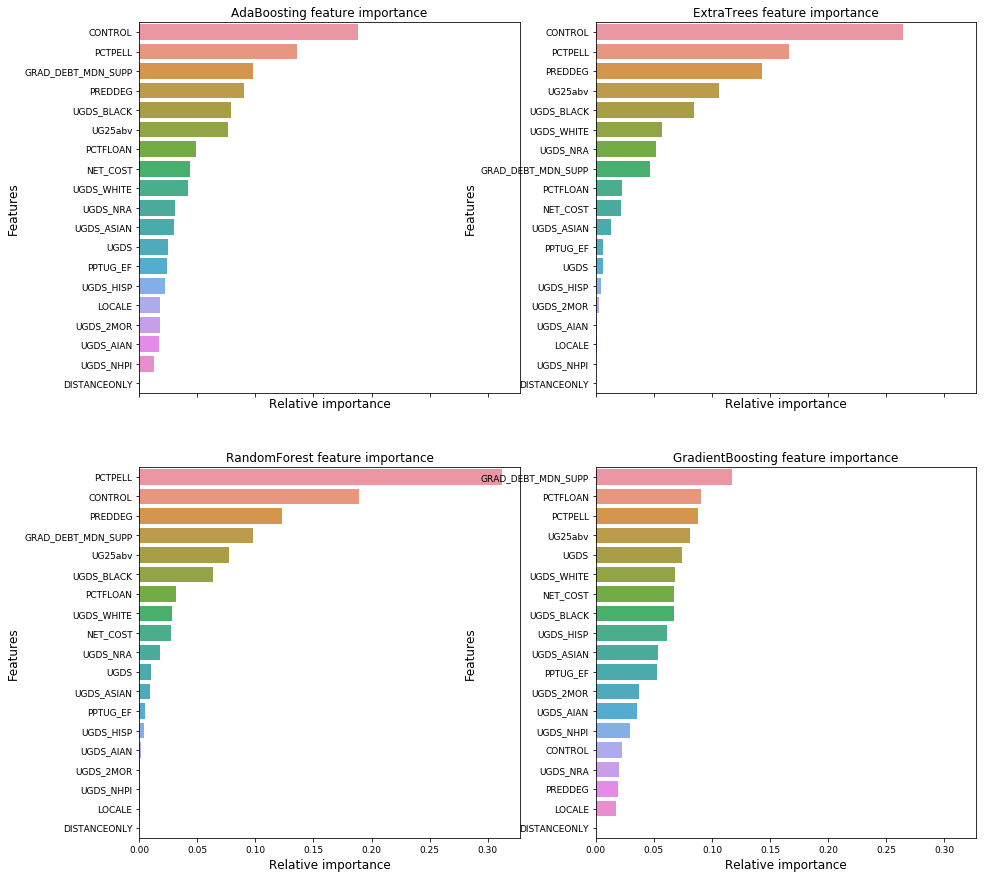

In [215]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=train_X.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1
        
plt.show()

In [220]:
df.columns

Index(['Unnamed: 0', 'PREDDEG', 'CONTROL', 'LOCALE', 'DISTANCEONLY', 'UGDS',
       'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN', 'UGDS_AIAN',
       'UGDS_NHPI', 'UGDS_2MOR', 'UGDS_NRA', 'PPTUG_EF', 'PCTPELL', 'PCTFLOAN',
       'UG25abv', 'GRAD_DEBT_MDN_SUPP', 'RPY_3YR_RT_SUPP', 'NET_COST',
       'Binary_25k'],
      dtype='object')

In [235]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
##############Classification#############
target_var = 'Binary_25k'
df= pd.read_csv('trans1.csv')
df = df.drop(['Unnamed: 0',"RPY_3YR_RT_SUPP"], axis=1)
#features = ['UGDS_AIAN', u'PREDDEG:UG25abv', 'UG25abv', 'PCTFLOAN', u'PPTUG_EF:PCTPELL', u'UG25abv:PCTPELL', 'CONTROL', u'UGDS:PCTFLOAN', 'PREDDEG', u'UG25abv:PCTFLOAN', u'PPTUG_EF:PREDDEG', u'GRAD_DEBT_MDN_SUPP:PCTFLOAN', u'CONTROL:PCTFLOAN', u'UG25abv:UGDS', u'GRAD_DEBT_MDN_SUPP:UG25abv', u'PPTUG_EF:PCTFLOAN', u'CONTROL:PREDDEG', u'PCTPELL:PCTFLOAN', u'PPTUG_EF:GRAD_DEBT_MDN_SUPP', u'CONTROL:UGDS', u'PCTPELL:UGDS', 'UGDS_ASIAN', u'PPTUG_EF:LOCALE', 'PCTPELL', u'CONTROL:PCTPELL', 'NET_COST', u'CONTROL:GRAD_DEBT_MDN_SUPP', u'GRAD_DEBT_MDN_SUPP:LOCALE', 'UGDS_NHPI', 'UGDS_HISP', 'GRAD_DEBT_MDN_SUPP', u'CONTROL:PPTUG_EF', u'PPTUG_EF:UG25abv', u'GRAD_DEBT_MDN_SUPP:UGDS', 'UGDS', u'PREDDEG:UGDS', 'UGDS_BLACK', u'PPTUG_EF:UGDS']
df = df.apply(lambda x: x.fillna(x.median()),axis=0)
train_X = df.loc[:, df.columns != target_var]
train_Y = df[target_var]
df_test = pd.read_csv('trans1_test.csv')
df_test = df_test.drop(['Unnamed: 0',"RPY_3YR_RT_SUPP"], axis=1)
df_test = df_test.apply(lambda x: x.fillna(x.median()),axis=0)
test_X = df_test.loc[:, df_test.columns != target_var]
test_Y = df_test[target_var]


In [236]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[30,50],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(train_X,train_Y)

ada_best = gsadaDTC.best_estimator_
gsadaDTC.best_score_

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   39.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed:  3.4min finished


0.91190132948902769

In [237]:
# RFC Parameters tunning # RFC Par 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [5],
              "max_features": [1, 3, 5,10],
              #"min_samples_split": [2, 3, 10],
              #"min_samples_leaf": [1, 3, 10],
              #"bootstrap": [False],
              "n_estimators" :[100,200,500],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(train_X,train_Y)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   25.0s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:   48.6s finished


0.8888354957552459

In [238]:
# Gradient boosting tunning
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,500],
              'learning_rate': [0.05,0.02,0.01,0.005],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(train_X,train_Y)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 480 out of 480 | elapsed:  3.3min finished


0.90853756206951786

In [239]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [0.1,1, 10, 100,1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(train_X,train_Y)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  6.1min finished


0.79304821399967962

In [244]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from vecstack import stacking
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix


# Caution! All models and parameter values are just 
# demonstrational and shouldn't be considered as recommended.
# Initialize 1-st level models.
models = [
    ada_best,
    GBC_best,
    RFC_best,  
    SVMC_best
#     XGBClassifier(seed = 0, n_jobs = -1, learning_rate = 0.1, 
#         n_estimators = 100, max_depth = 3)]
    ]
    
# Compute stacking features
S_train, S_test = stacking(models, train_X.values, train_Y.values, test_X.values, 
    regression = False, metric = accuracy_score, n_folds = 10, 
    stratified = True, shuffle = True, random_state = 0, verbose = 2)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [4]

model  0:     [AdaBoostClassifier]
    fold  0:  [0.90894569]
    fold  1:  [0.89600000]
    fold  2:  [0.92628205]
    fold  3:  [0.94070513]
    fold  4:  [0.89903846]
    fold  5:  [0.91826923]
    fold  6:  [0.88942308]
    fold  7:  [0.91666667]
    fold  8:  [0.90224359]
    fold  9:  [0.90384615]
    ----
    MEAN:     [0.91014200] + [0.01469436]
    FULL:     [0.91013936]

model  1:     [GradientBoostingClassifier]
    fold  0:  [0.89936102]
    fold  1:  [0.88960000]
    fold  2:  [0.90865385]
    fold  3:  [0.93910256]
    fold  4:  [0.91185897]
    fold  5:  [0.91185897]
    fold  6:  [0.89583333]
    fold  7:  [0.91185897]
    fold  8:  [0.90224359]
    fold  9:  [0.89423077]
    ----
    MEAN:     [0.90646020] + [0.01331432]
    FULL:     [0.90645523]

model  2:     [RandomForestClassifier]
    fold  0:  [0.89456869]
    fold  1:  [0.86560000]
   

In [245]:
model = LogisticRegression()

# Fit 2-nd level model
model.fit(S_train, train_Y)

# Predict
y_pred = model.predict(S_train)


# Final prediction score
print('Final train mse score: [%.8f]' % accuracy_score(train_Y, y_pred))

# Predict
y_pred = model.predict(S_test)

# Final prediction score
print('Final test mse score: [%.8f]' % accuracy_score(test_Y, y_pred))

Final train mse score: [0.91110043]
Final test mse score: [0.90262652]


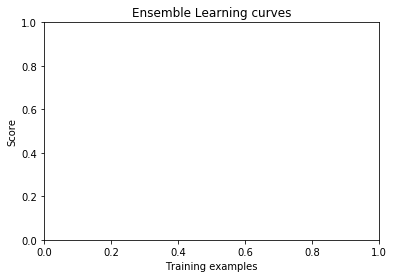

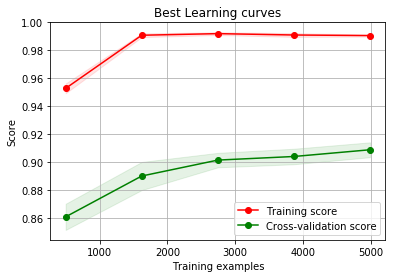

In [247]:
g = plot_learning_curve(GBC_best,"Best Learning curves",train_X,train_Y,cv=kfold)

In [ ]:
#############Evaluation###############

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
    return plt

#g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",x_train,y_train,cv=kfold)

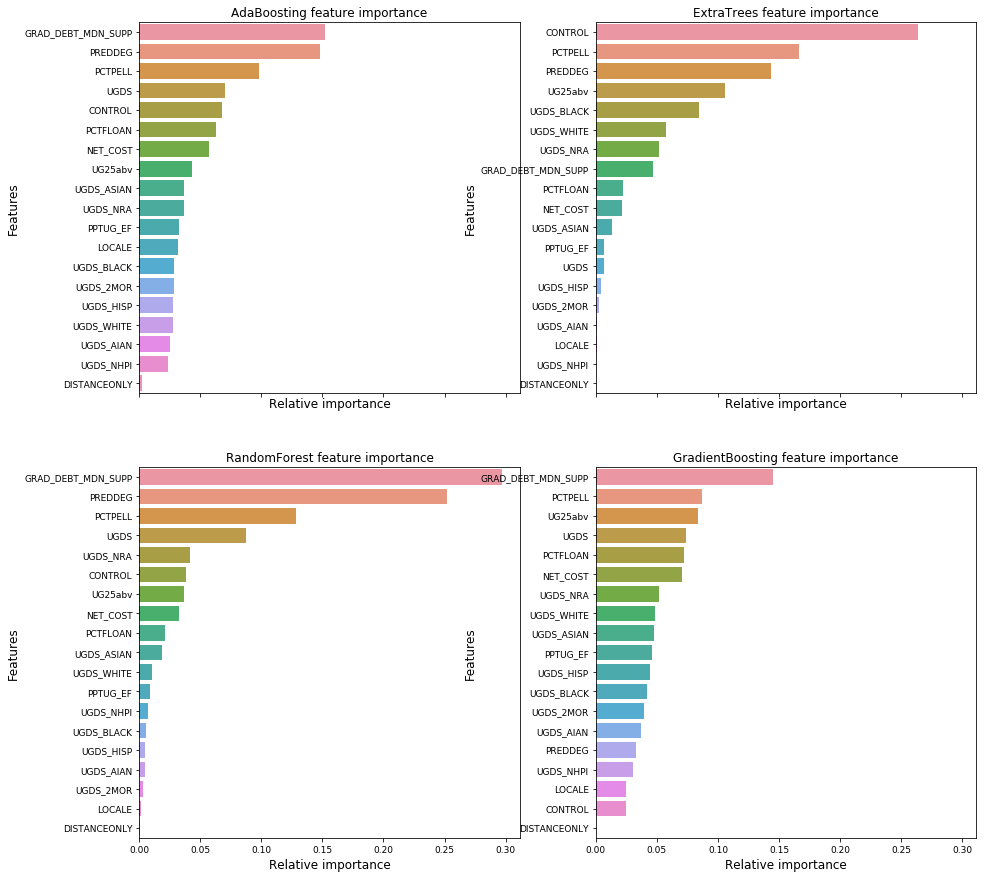

In [250]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=train_X.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1
        
plt.show()